**Dependencies**

In [1]:
import pandas as pd 
import numpy as np 

import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn import model_selection

from sklearn.metrics import accuracy_score, f1_score 
from sklearn.metrics import roc_auc_score

# Exploratory Data Analysis (EDA) and Feature Engineering

In [2]:
data = pd.read_excel("ICUfinal.xlsx")
data.head()

,Unnamed: 0,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,BILLIRUBIN_MIN,BILLIRUBIN_MAX,BILLIRUBIN_DIFF,BLAST_MEDIAN,BLAST_MEAN,...,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,tags,ICU
0,0,0,1,60th,0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,"Motor Neurone Disease, Smoker",0
1,1,0,1,60th,0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.333333,-0.230769,-0.132075,-0.593220,0.535714,0.578947,0.333333,-0.230769,-0.132075,-0.586207,0.535714,0.578947,0.443299,0.0000,-0.025641,-0.500000,0.714286,0.838384,-0.076923,-0.459459,-0.313433,-0.636364,0.246377,0.578947,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,"Motor Neurone Disease, Smoker",0
2,2,0,1,60th,0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,-0.938950,-0.938950,-1.0,-1.0,-1.0,...,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4-6,"Motor Neurone Disease, Smoker",0
3,3,0,1,60th,0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-0.107143,0.736842,NaN,NaN,NaN,NaN,-0.107143,0.736842,NaN,NaN,NaN,NaN,0.318681,0.898990,NaN,NaN,NaN,NaN,-0.275362,0.736842,NaN,NaN,NaN,NaN,-1.000000,-1.000000,NaN,NaN,NaN,NaN,-1.000000,-1.000000,6-12,"Motor Neurone Disease, Smoker",0
4,4,0,1,60th,0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,-1.0,-0.871658,-0.871658,-0.871658,-0.871658,-1.0,-0.863874,-0.863874,-0.863874,-0.863874,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.414634,-0.414634,-0.414634,-0.414634,-1.0,-0.979069,-0.979069,-0.979069,-0.979069,-1.0,-1.0,-1.0,...,-1.0,-0.243021,-0.338537,-0.213031,-0.317859,0.033779,0.665932,-0.283951,-0.376923,-0.188679,-0.379310,0.035714,0.631579,-0.340206,-0.4875,-0.572650,-0.857143,0.098901,0.797980,-0.076923,0.286486,0.298507,0.272727,0.362319,0.9473

Note that As stated in data description section, a model with only the "0-2 window" is more clincally relevant. Therfore, I will also just this column.

As you can see in the above, the first 8 columns are categorical.

## Cleaning the data

### Conver the 'tags' column to one-hot

In [3]:
# adding the 'tags' column to the categorical columns
tags = data['tags']
data.drop('tags', inplace=True, axis = 1)

The column named "Tags" is showing the DISEASE kind that the patient has. Therefore we should convert it to one-hot vectors and add them to the categorical columns of our data.

In [4]:
tags.unique()

array(['Motor Neurone Disease, Smoker', nan, 'Motor Neurone Disease',
       'Lung cancer', 'asthma, Kidney disease, Motor Neurone Disease',
       'asthma, Motor Neurone Disease', 'Smoker',
       'asthma, Kidney disease', 'asthma',
       'heart disease, Kidney disease', 'heart disease',
       'asthma, Motor Neurone Disease, Smoker',
       'Lung cancer, asthma, Motor Neurone Disease, Smoker',
       'Lung cancer, Motor Neurone Disease',
       'Lung cancer, asthma, Motor Neurone Disease', 'asthma, Smoker',
       'Kidney disease', 'heart disease, Motor Neurone Disease',
       'Lung cancer, asthma', 'heart disease, asthma, Smoker',
       'heart disease, asthma, Motor Neurone Disease',
       'Lung cancer, heart disease', 'Lung cancer, asthma, Smoker',
       'heart disease, asthma', 'Lung cancer, Smoker',
       'Lung cancer, heart disease, asthma, Motor Neurone Disease',
       'Lung cancer, asthma, Kidney disease, Motor Neurone Disease, Smoker',
       'Lung cancer, heart diseas

We can see that we have 6 kind of desease: Motor Neurone Disease, Smoker, Lung cancer, asthma, Kidney disease ,and heart disease.

In [5]:
tags_np = tags.to_numpy()
for i in range(0, 1921, 5):
  if pd.isnull(tags_np[i]) == False:
    tags_np[i:i+5] = tags_np[i] 
  elif  pd.isnull(tags_np[i+1]) == False:
    tags_np[i:i+5] = tags_np[i+1]
  elif pd.isnull(tags_np[i+2]) == False:
    tags_np[i:i+5] = tags_np[i+2]
  elif pd.isnull(tags_np[i+3]) == False:
    tags_np[i:i+5] = tags_np[i+3]
  elif pd.isnull(tags_np[i+4]) == False:
    tags_np[i:i+5] = tags_np[i+4]

In [6]:
disease_columns = np.zeros((1925, 6))
for i in range(0, 1920, 5):
  if pd.isnull(tags_np[i]):
    continue
  if 'Motor Neurone Disease' in tags_np[i]:
    disease_columns[i:i+5, 0] = np.ones((5))
  if 'Smoker' in tags_np[i]:
    disease_columns[i:i+5, 1] = np.ones((5))
  if 'Lung cancer' in tags_np[i]:
    disease_columns[i:i+5, 2] = np.ones((5))
  if 'asthma' in tags_np[i]:
    disease_columns[i:i+5, 3] = np.ones((5))
  if 'Kidney disease' in tags_np[i]:
    disease_columns[i:i+5, 4] = np.ones((5))
  if 'heart disease' in tags_np[i]:
    disease_columns[i:i+5, 5] = np.ones((5))

In [7]:
data.insert(8, 'Motor Neurone Disease', disease_columns[:,0])
data.insert(9, 'Smoker', disease_columns[:,1])
data.insert(10, 'Lung cancer', disease_columns[:,2])
data.insert(11, 'asthma', disease_columns[:,3])
data.insert(12, 'Kidney disease', disease_columns[:,4])
data.insert(13, 'heart disease', disease_columns[:,5])
data.head(1)

,Unnamed: 0,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,HTN,IMMUNOCOMPROMISED,OTHER,Motor Neurone Disease,Smoker,Lung cancer,asthma,Kidney disease,heart disease,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,0,1,60th,0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.08642,-0.230769,-0.283019,-0.59322,-0.285714,0.736842,0.08642,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0,-0.162393,-0.5,0.208791,0.89899,-0.247863,-0.459459,-0.432836,-0.636364,-0.42029,0.736842,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0-2,0


### Filling NAN Values

The dataset provider mentioned that it is better to fill missing values with respect to previous or next entry of the same patient.

In [8]:
all = data.columns
clean_data = pd.concat([data.iloc[:, 0], data.groupby('PATIENT_VISIT_IDENTIFIER', as_index= False)[all[1:]].fillna(method = 'bfill').fillna(method = 'ffill')], ignore_index = True, axis = 1)
clean_data.columns = all
clean_data.shape

(1925, 232)

### Early Prediction

Here we want to exclude the data that contains ICU = 1 and WINDOW = 0-2. Also, we wish to predict the ICU Admission in **window ABOVE 12** from the information we have in **window 0-2**. (Because, as mentioned in the dataset description, the data is in the first row is more **Clinically Relevant** for predicting the ICU Admission in the fifth row.)

In [9]:
first_to_icu = clean_data.query('ICU == 1 and WINDOW == "0-2"')['PATIENT_VISIT_IDENTIFIER'].values
clean_data = clean_data[~data['PATIENT_VISIT_IDENTIFIER'].isin(first_to_icu)]

In [10]:
def find_window(rows):
  if np.any(rows['ICU']):
      rows.loc[rows['WINDOW'] == '0-2', 'ICU'] = 1
  return rows.loc[rows['WINDOW'] == '0-2']

In [11]:
clean_data = clean_data.groupby('PATIENT_VISIT_IDENTIFIER', as_index=False).apply(find_window)
clean_data.drop(['PATIENT_VISIT_IDENTIFIER', 'WINDOW'], inplace=True, axis=1)
clean_data = clean_data.droplevel(1)

In [12]:
clean_data.dropna(inplace=True)
clean_data.drop(data.columns[0], axis=1, inplace=True)
clean_data.head()

,AGE_ABOVE65,AGE_PERCENTIL,GENDER,HTN,IMMUNOCOMPROMISED,OTHER,Motor Neurone Disease,Smoker,Lung cancer,asthma,Kidney disease,heart disease,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,BILLIRUBIN_MIN,...,DIMER_MIN,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,ICU
0,1,60th,0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,-0.938950,...,-0.994912,-0.994912,-1.0,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1
1,0,10th,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,-0.938950,...,-0.978029,-0.978029,-1.0,-0.489712,-0.685470,-0.048218,-0.645951,0.357143,0.935673,-0.506173,-0.815385,-0.056604,-0.517241,0.357143,0.947368,-0.525773,-0.5125,-0.111111,-0.714286,0.604396,0.959596,-0.435897,-0.491892,0.000000,-0.575758,0.101449,1.000000,-0.547826,-0.533742,-0.603053,-0.764706,-1.000000,-0.959596,-0.515528,-0.351328,-0.747001,-0.756272,-1.000000,-0.961262,1
2,0,40th,1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.263158,-0.263158,-0.263158,-0.263158,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.972789,-0.972789,-0.972789,...,-0.978029,-0.978029,-1.0,0.012346,-0.369231,-0.528302,-0.457627,-0.285714,0.684211,0.012346,-0.369231,-0.528302,-0.448276,-0.285714,0.684211,0.175258,-0.1125,-0.384615,-0.357143,0.208791,0.878788,-0.299145,-0.556757,-0.626866,-0.515152,-0.420290,0.684211,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0
3,0,10th,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.935113,-0.935113,-0.935113,...,-1.000000,-1.000000,-1.0,0.333333,-0.153846,0.160377,-0.593220,0.285714,0.868421,0.333333,-0.153846,0.160377,-0.586207,0.285714,0.868421,0.443299,0.0000,0.196581,-0.571429,0.538462,0.939394,-0.076923,-0.351351,-0.044776,-0.575758,0.072464,0.894737,-1.000000,-0.877301,-0.923664,-0.882353,-0.952381,-0.979798,-1.000000,-0.883669,-0.956805,-0.870968,-0.953536,-0.98

Let's check the statistics of our clean data.

In [13]:
clean_data.describe()

,AGE_ABOVE65,GENDER,HTN,IMMUNOCOMPROMISED,OTHER,Motor Neurone Disease,Smoker,Lung cancer,asthma,Kidney disease,heart disease,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,BILLIRUBIN_MIN,BILLIRUBIN_MAX,...,DIMER_MIN,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,ICU
count,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.0,353.000000,353.000000,353.000000,353.000000,353.0,353.000000,353.000000,353.000000,353.000000,353.0,353.000000,353.000000,353.000000,353.000000,353.0,353.000000,353.000000,353.000000,353.000000,353.0,353.000000,353.000000,353.000000,353.000000,...,353.000000,353.000000,353.0,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000
mean,0.456091,0.379603,0.192635,0.161473,0.832861,0.155807,0.065156,0.147309,0.130312,0.028329,0.031161,0.576935,0.576935,0.576935,0.576935,-1.0,-0.997849,-0.997849,-0.997849,-0.997849,-1.0,-0.958501,-0.958501,-0.958501,-0.958501,-1.0,-0.318317,-0.318317,-0.318317,-0.318317,-1.0,-0.320252,-0.320252,-0.320252,-0.320252,-1.0,-0.945669,-0.945669,-0.945669,-0.945669,...,-0.955228,-0.955228,-1.0,-0.037525,-0.313538,-0.240751,-0.466909,0.108997,0.752296,-0.038681,-0.314666,-0.239617,-0.454918,0.107193,0.753765,0.107503,-0.087606,-0.143653,-0.390935,0.436354,0.896758,-0.312559,-0.499916,-0.383197,-0.504335,-0.076569,0.769644,-0.956497,-0.959923,-0.965962,-0.961673,-0.964185,-0.985178,-0.962087,-0.957925,-0.975893,-0.963973,-0.964688,-0.985201,0.461756
std,0.498775,0.485977,0.394928,0.368489,0.373629,0.363187,0.247151,0.354917,0.337124,0.166145,0.174001,0.134367,0.134367,0.134367,0.134367,0.0,0.024311,0.024311,0.024311,0.024311,0.0,0.114487,0.114487,0.114487,0.114487,0.0,0.032346,0.032346,0.032346,0.032346,0.0,0.089521,0.089521,0.089521,0.089521,0.0,0.044198,0.044198,0.044198,0.044198,...,0.141804,0.141804,0.0,0.264747,0.292891,0.277924,0.221720,0.269084,0.156495,0.268849,0.293767,0.285744,0.234702,0.274780,0.161218,0.235611,0.245818,0.252605,0.232891,0.165768,0.062885,0.186477,0.211540,0.225072,0.209541,0.229447,0.159207,0.113794,0.114892,0.096374,0.110501,0.088236,0.032784,0.107646,0.118875,0.060342,0.095302,0.086411,0.033170,0.499243
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.578947,-0.578947,-0.578947,-0.578947,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.0000

In [14]:
print("The cleaned data has {:d} samples, each with {:d} features.".format(clean_data.shape[0], clean_data.shape[1]))

The cleaned data has 353 samples, each with 229 features.


## Some Visualization

### ICU Admission Distribution

Let's see what's the distribution of the people in the dataset with respect to ICU admission.

0    190
1    163
Name: ICU, dtype: int64


Text(0, 0.5, '# of People')

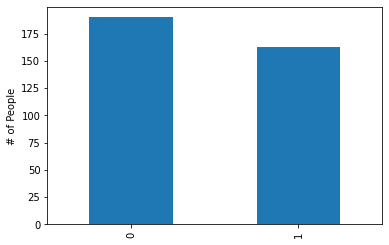

In [15]:
print(clean_data['ICU'].value_counts())
clean_data['ICU'].value_counts().plot(kind = 'bar')
plt.ylabel("# of People")

### Age Distribution

Now, let's see what is the **Age** distribution and check it's relation to ICU admission. 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



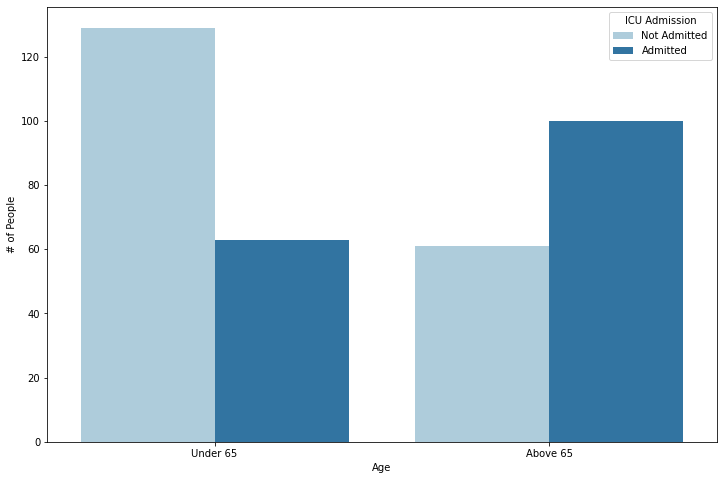

In [16]:
plt.figure(figsize=(12,8))
ages = sns.countplot(clean_data['AGE_ABOVE65'], hue='ICU', data=clean_data, palette= 'Paired')
ages.set_xticklabels(['Under 65','Above 65'])
plt.xlabel('Age')
plt.ylabel('# of People')
plt.legend(title = 'ICU Admission',labels=['Not Admitted', 'Admitted'])
plt.show()

Now from the above chart, we can clearly see that age above 65 increases the chance of ICU admission.

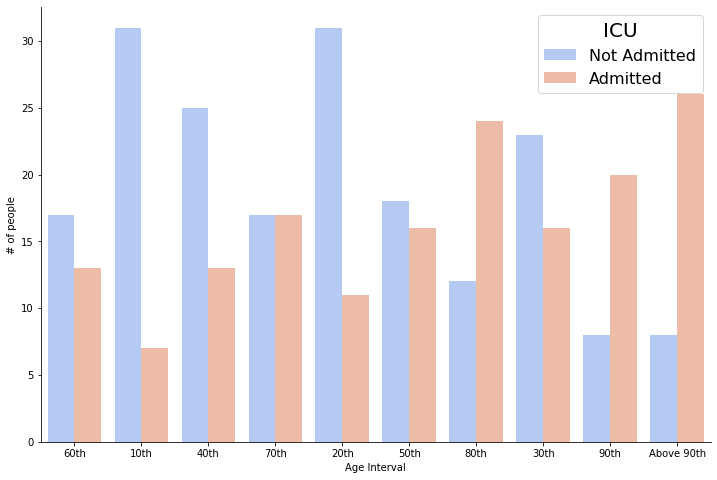

In [17]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.countplot(x = "AGE_PERCENTIL",
              data = clean_data,
              ax = ax,
              hue = "ICU",
              palette="coolwarm")
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ["Not Admitted", "Admitted"], title='ICU', fontsize=16, title_fontsize=20)
sns.despine(right = True)
plt.ylabel("# of people")
plt.xlabel("Age Interval")
plt.show()

### Gender Distribution

Now, let's see what is the **Gender** distribution and check it's relation to ICU admission. 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



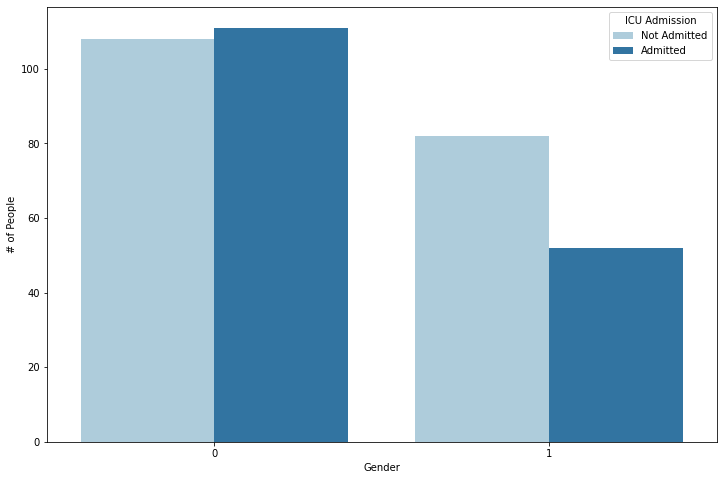

In [18]:
plt.figure(figsize=(12,8))
ages = sns.countplot(clean_data['GENDER'], hue='ICU', data=clean_data, palette= 'Paired')
ages.set_xticklabels(['0','1'])
plt.xlabel('Gender')
plt.ylabel('# of People')
plt.legend(title = 'ICU Admission',labels=['Not Admitted', 'Admitted'])
plt.show()

### Disease Distribution 

Here we want to check what kind of desease might have affected the ICU admission.

In [19]:
disease_names = ['Motor Neurone Disease', 'Smoker', 'Lung cancer', 'asthma', 'Kidney disease' , 'heart disease', 'HTN', 'IMMUNOCOMPROMISED', 'OTHER', 'ICU']
disease_data = clean_data[disease_names]

Text(0, 0.5, 'Frequency')

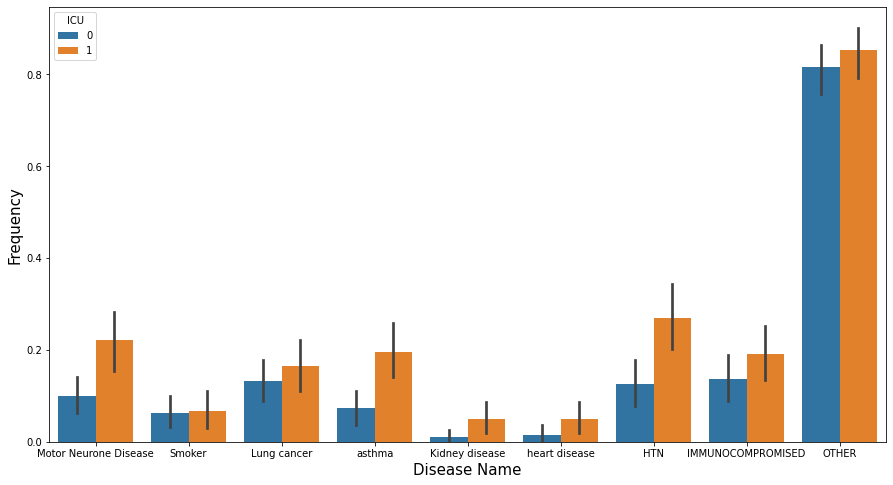

In [20]:
plt.figure(figsize=(15,8))
sns.barplot(x='variable', y='value', data= disease_data.melt(id_vars='ICU'), hue='ICU', palette= 'tab10')
plt.xlabel('Disease Name', fontsize=15)
plt.ylabel('Frequency', fontsize=15)

### Vital Signs Distributions

There are various Vital Signs that have been reported in this dataset. The Vital Signs in the dataset include : BLOODPRESSURE DIASTOLIC, BLOODPRESSURE SISTOLIC, HEART RATE, RESPIRATORY RATE, TEMPERATURE, and OXYGEN SATURATION. We have the information about their mean value, median, min, max, diff and rel values in the dataset. 

In [21]:
vital = clean_data.iloc[:, 192:]
vital.head(1)

,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,ICU
0,0.08642,-0.230769,-0.283019,-0.59322,-0.285714,0.736842,0.08642,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0,-0.162393,-0.5,0.208791,0.89899,-0.247863,-0.459459,-0.432836,-0.636364,-0.42029,0.736842,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1


Text(0, 0.5, 'Vital Sign Name')

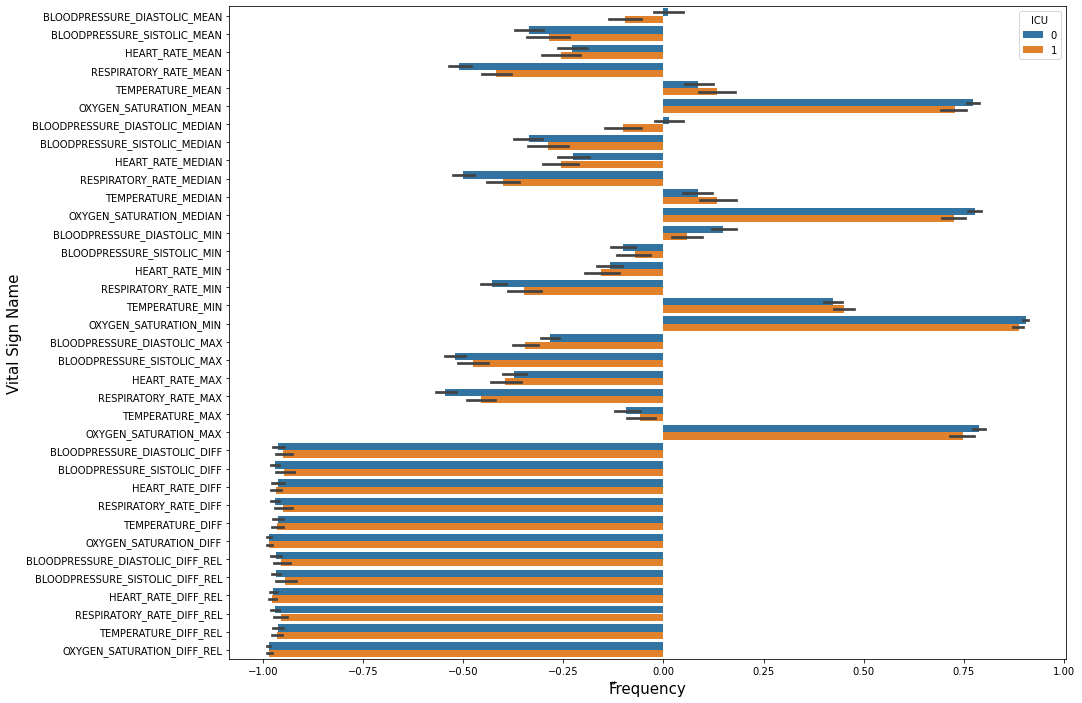

In [22]:
plt.figure(figsize=(15,12))
sns.barplot(x='value', y='variable', data= vital.melt(id_vars='ICU'), hue='ICU', palette= 'tab10')
plt.xlabel('ّFrequency', fontsize=15)
plt.ylabel('Vital Sign Name', fontsize=15)

## Some Feature Engineering

### Removing Low-Variance Values

There are many other medical tests that we have their results in our dataset. Also, we have the min, max, median, mean, diff values for each of them. We should decide whether we want to keep them for modeling or not. Let's have a look at these columns.

In [23]:
medical_test = clean_data.iloc[:, 12:192]
medical_test.head()

,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,BILLIRUBIN_MIN,BILLIRUBIN_MAX,BILLIRUBIN_DIFF,BLAST_MEDIAN,BLAST_MEAN,BLAST_MIN,BLAST_MAX,BLAST_DIFF,CALCIUM_MEDIAN,CALCIUM_MEAN,CALCIUM_MIN,CALCIUM_MAX,CALCIUM_DIFF,...,SAT02_ARTERIAL_MEDIAN,SAT02_ARTERIAL_MEAN,SAT02_ARTERIAL_MIN,SAT02_ARTERIAL_MAX,SAT02_ARTERIAL_DIFF,SAT02_VENOUS_MEDIAN,SAT02_VENOUS_MEAN,SAT02_VENOUS_MIN,SAT02_VENOUS_MAX,SAT02_VENOUS_DIFF,SODIUM_MEDIAN,SODIUM_MEAN,SODIUM_MIN,SODIUM_MAX,SODIUM_DIFF,TGO_MEDIAN,TGO_MEAN,TGO_MIN,TGO_MAX,TGO_DIFF,TGP_MEDIAN,TGP_MEAN,TGP_MIN,TGP_MAX,TGP_DIFF,TTPA_MEDIAN,TTPA_MEAN,TTPA_MIN,TTPA_MAX,TTPA_DIFF,UREA_MEDIAN,UREA_MEAN,UREA_MIN,UREA_MAX,UREA_DIFF,DIMER_MEDIAN,DIMER_MEAN,DIMER_MIN,DIMER_MAX,DIMER_DIFF
0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,-0.938950,-0.938950,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.183673,0.183673,0.183673,0.183673,-1.0,...,0.939394,0.939394,0.939394,0.939394,-1.0,0.345679,0.345679,0.345679,0.345679,-1.0,-0.028571,-0.028571,-0.028571,-0.028571,-1.0,-0.997201,-0.997201,-0.997201,-0.997201,-1.0,-0.990854,-0.990854,-0.990854,-0.990854,-1.0,-0.825613,-0.825613,-0.825613,-0.825613,-1.0,-0.836145,-0.836145,-0.836145,-0.836145,-1.0,-0.994912,-0.994912,-0.994912,-0.994912,-1.0
1,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,-0.938950,-0.938950,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.357143,0.357143,0.357143,0.357143,-1.0,...,0.939394,0.939394,0.939394,0.939394,-1.0,0.345679,0.345679,0.345679,0.345679,-1.0,0.085714,0.085714,0.085714,0.085714,-1.0,-0.995428,-0.995428,-0.995428,-0.995428,-1.0,-0.986662,-0.986662,-0.986662,-0.986662,-1.0,-0.846633,-0.846633,-0.846633,-0.846633,-1.0,-0.836145,-0.836145,-0.836145,-0.836145,-1.0,-0.978029,-0.978029,-0.978029,-0.978029,-1.0
2,-0.263158,-0.263158,-0.263158,-0.263158,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.972789,-0.972789,-0.972789,-0.972789,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.326531,0.326531,0.326531,0.326531,-1.0,...,0.939394,0.939394,0.939394,0.939394,-1.0,0.580247,0.580247,0.580247,0.580247,-1.0,0.200000,0.200000,0.200000,0.200000,-1.0,-0.989549,-0.989549,-0.989549,-0.989549,-1.0,-0.956555,-0.956555,-0.956555,-0.956555,-1.0,-0.846633,-0.846633,-0.846633,-0.846633,-1.0,-0.937349,-0.937349,-0.937349,-0.937349,-1.0,-0.978029,-0.978029,-0.978029,-0.978029,-1.0
3,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.935113,-0.935113,-0.935113,-0.935113,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.357143,0.357143,0.357143,0.357143,-1.0,...,0.939394,0.939394,0.939394,0.939394,-1.0,0.345679,0.345679,0.345679,0.345679,-1.0,0.142857,0.142857,0.142857,0.142857,-1.0,-0.998507,-0.998507,-0.998507,-0.998507,-1.0,-0.991235,-0.991235,-0.991235,-0.991235,-1.0,-0.846633,-0.846633,-0.846633,-0.846633,-1.0,-0.903614,-0.903614,-0.903614,-0.903614,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0
4,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,-0.938950,-0.938950,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.357143,0.357143,0.357143,0.357143,-1.0,...,0.939394,0.9393

As we can see from the above results, we have 180 of these features which are **a lot**! 

If you look closely at the data, you will notice that the **DIFF** columns are all the same! Therefore, they will have a variance of 0 and we should ommit them from our data.

In [24]:
diff_column_numbers = [i for i in range(4, 180, 5)]
medical_test.drop(columns=medical_test.columns[diff_column_numbers], inplace=True)
print('DIFF' in medical_test.columns)
medical_test.head(10)

False


,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,BILLIRUBIN_MIN,BILLIRUBIN_MAX,BLAST_MEDIAN,BLAST_MEAN,BLAST_MIN,BLAST_MAX,CALCIUM_MEDIAN,CALCIUM_MEAN,CALCIUM_MIN,CALCIUM_MAX,CREATININ_MEDIAN,CREATININ_MEAN,CREATININ_MIN,CREATININ_MAX,FFA_MEDIAN,FFA_MEAN,FFA_MIN,FFA_MAX,...,PLATELETS_MEDIAN,PLATELETS_MEAN,PLATELETS_MIN,PLATELETS_MAX,POTASSIUM_MEDIAN,POTASSIUM_MEAN,POTASSIUM_MIN,POTASSIUM_MAX,SAT02_ARTERIAL_MEDIAN,SAT02_ARTERIAL_MEAN,SAT02_ARTERIAL_MIN,SAT02_ARTERIAL_MAX,SAT02_VENOUS_MEDIAN,SAT02_VENOUS_MEAN,SAT02_VENOUS_MIN,SAT02_VENOUS_MAX,SODIUM_MEDIAN,SODIUM_MEAN,SODIUM_MIN,SODIUM_MAX,TGO_MEDIAN,TGO_MEAN,TGO_MIN,TGO_MAX,TGP_MEDIAN,TGP_MEAN,TGP_MIN,TGP_MAX,TTPA_MEDIAN,TTPA_MEAN,TTPA_MIN,TTPA_MAX,UREA_MEDIAN,UREA_MEAN,UREA_MIN,UREA_MAX,DIMER_MEDIAN,DIMER_MEAN,DIMER_MIN,DIMER_MAX
0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-0.317073,-0.317073,-0.317073,-0.317073,-0.938950,-0.938950,-0.938950,-0.938950,-1.0,-1.0,-1.0,-1.0,0.183673,0.183673,0.183673,0.183673,-0.868365,-0.868365,-0.868365,-0.868365,-0.742004,-0.742004,-0.742004,-0.742004,...,-0.540721,-0.540721,-0.540721,-0.540721,-0.518519,-0.518519,-0.518519,-0.518519,0.939394,0.939394,0.939394,0.939394,0.345679,0.345679,0.345679,0.345679,-0.028571,-0.028571,-0.028571,-0.028571,-0.997201,-0.997201,-0.997201,-0.997201,-0.990854,-0.990854,-0.990854,-0.990854,-0.825613,-0.825613,-0.825613,-0.825613,-0.836145,-0.836145,-0.836145,-0.836145,-0.994912,-0.994912,-0.994912,-0.994912
1,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-0.317073,-0.317073,-0.317073,-0.317073,-0.938950,-0.938950,-0.938950,-0.938950,-1.0,-1.0,-1.0,-1.0,0.357143,0.357143,0.357143,0.357143,-0.912243,-0.912243,-0.912243,-0.912243,-0.742004,-0.742004,-0.742004,-0.742004,...,-0.399199,-0.399199,-0.399199,-0.399199,-0.703704,-0.703704,-0.703704,-0.703704,0.939394,0.939394,0.939394,0.939394,0.345679,0.345679,0.345679,0.345679,0.085714,0.085714,0.085714,0.085714,-0.995428,-0.995428,-0.995428,-0.995428,-0.986662,-0.986662,-0.986662,-0.986662,-0.846633,-0.846633,-0.846633,-0.846633,-0.836145,-0.836145,-0.836145,-0.836145,-0.978029,-0.978029,-0.978029,-0.978029
2,-0.263158,-0.263158,-0.263158,-0.263158,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-0.317073,-0.317073,-0.317073,-0.317073,-0.972789,-0.972789,-0.972789,-0.972789,-1.0,-1.0,-1.0,-1.0,0.326531,0.326531,0.326531,0.326531,-0.968861,-0.968861,-0.968861,-0.968861,-0.194030,-0.194030,-0.194030,-0.194030,...,-0.564753,-0.564753,-0.564753,-0.564753,-0.777778,-0.777778,-0.777778,-0.777778,0.939394,0.939394,0.939394,0.939394,0.580247,0.580247,0.580247,0.580247,0.200000,0.200000,0.200000,0.200000,-0.989549,-0.989549,-0.989549,-0.989549,-0.956555,-0.956555,-0.956555,-0.956555,-0.846633,-0.846633,-0.846633,-0.846633,-0.937349,-0.937349,-0.937349,-0.937349,-0.978029,-0.978029,-0.978029,-0.978029
3,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-0.317073,-0.317073,-0.317073,-0.317073,-0.935113,-0.935113,-0.935113,-0.935113,-1.0,-1.0,-1.0,-1.0,0.357143,0.357143,0.357143,0.357143,-0.913659,-0.913659,-0.913659,-0.913659,-0.829424,-0.829424,-0.829424,-0.829424,...,-0.457944,-0.457944,-0.457944,-0.457944,-0.592593,-0.592593,-0.592593,-0.592593,0.939394,0.939394,0.939394,0.939394,0.345679,0.345679,0.345679,0.345679,0.142857,0.142857,0.142857,0.142857,-0.998507,-0.998507,-0.998507,-0.998507,-0.991235,-0.991235,-0.991235,-0.991235,-0.846633,-0.846633,-0.846633,-0.846633,-0.903614,-0.903614,-0.903614,-0.903614,-1.000000,-1.000000,-1.000000,-1.00

### Removing High Correlation Features

Now, we have 4 columns for each feature: **MEDIAN, MEAN, MIN, MAX**.

Let's Draw the correlation matrix of some of them:

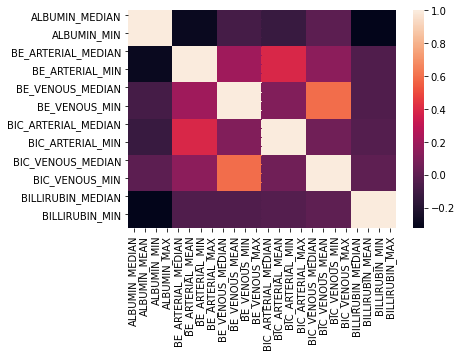

In [25]:
sns.heatmap(medical_test.iloc[:, 0:24].corr(), annot=False);

Now, it is obvious from the above correlation map and also from the latest printed table that only one of these four values is enough (I mean between median, mean, min, max), because the corrrelation is 1 and they are exactly equal. Therefore I choose to just keep the **mean** columns.

In [26]:
mean_column_numbers = [i for i in range(1, 144, 4)]
others = list(set(range(144)) - set(mean_column_numbers))
medical_test.drop(columns=medical_test.columns[others], inplace=True)
print(medical_test.shape)
medical_test.head()

(353, 36)


,ALBUMIN_MEAN,BE_ARTERIAL_MEAN,BE_VENOUS_MEAN,BIC_ARTERIAL_MEAN,BIC_VENOUS_MEAN,BILLIRUBIN_MEAN,BLAST_MEAN,CALCIUM_MEAN,CREATININ_MEAN,FFA_MEAN,GGT_MEAN,GLUCOSE_MEAN,HEMATOCRITE_MEAN,HEMOGLOBIN_MEAN,INR_MEAN,LACTATE_MEAN,LEUKOCYTES_MEAN,LINFOCITOS_MEAN,NEUTROPHILES_MEAN,P02_ARTERIAL_MEAN,P02_VENOUS_MEAN,PC02_ARTERIAL_MEAN,PC02_VENOUS_MEAN,PCR_MEAN,PH_ARTERIAL_MEAN,PH_VENOUS_MEAN,PLATELETS_MEAN,POTASSIUM_MEAN,SAT02_ARTERIAL_MEAN,SAT02_VENOUS_MEAN,SODIUM_MEAN,TGO_MEAN,TGP_MEAN,TTPA_MEAN,UREA_MEAN,DIMER_MEAN
0,0.605263,-1.0,-1.0,-0.317073,-0.317073,-0.938950,-1.0,0.183673,-0.868365,-0.742004,-0.945093,-0.891993,0.090147,0.109756,-0.932246,1.000000,-0.835844,-0.914938,-0.868747,-0.170732,-0.704142,-0.77931,-0.754601,-0.875236,0.234043,0.363636,-0.540721,-0.518519,0.939394,0.345679,-0.028571,-0.997201,-0.990854,-0.825613,-0.836145,-0.994912
1,0.605263,-1.0,-1.0,-0.317073,-0.317073,-0.938950,-1.0,0.357143,-0.912243,-0.742004,-0.958528,-0.780261,0.144654,0.158537,-0.959849,1.000000,-0.382773,-0.908714,-0.412965,-0.170732,-0.704142,-0.77931,-0.754601,-0.939887,0.234043,0.363636,-0.399199,-0.703704,0.939394,0.345679,0.085714,-0.995428,-0.986662,-0.846633,-0.836145,-0.978029
2,-0.263158,-1.0,-1.0,-0.317073,-0.317073,-0.972789,-1.0,0.326531,-0.968861,-0.194030,-0.316589,-0.891993,-0.203354,-0.219512,-0.959849,-0.828421,-0.729239,-0.836100,-0.784714,-0.170732,-0.633136,-0.77931,-0.779141,-0.503592,0.234043,0.363636,-0.564753,-0.777778,0.939394,0.580247,0.200000,-0.989549,-0.956555,-0.846633,-0.937349,-0.978029
3,0.605263,-1.0,-1.0,-0.317073,-0.317073,-0.935113,-1.0,0.357143,-0.913659,-0.829424,-0.938084,-0.851024,0.358491,0.304878,-0.959849,1.000000,-0.702202,-0.641079,-0.812725,-0.170732,-0.704142,-0.77931,-0.754601,-0.990926,0.234043,0.363636,-0.457944,-0.592593,0.939394,0.345679,0.142857,-0.998507,-0.991235,-0.846633,-0.903614,-1.000000
4,0.605263,-1.0,-1.0,-0.317073,-0.317073,-0.938950,-1.0,0.357143,-0.891012,-0.742004,-0.958528,-0.891993,0.291405,0.243902,-0.959849,1.000000,-0.706450,-0.340249,-0.846339,-0.170732,-0.704142,-0.77931,-0.754601,-0.997732,0.234043,0.363636,-0.292390,-0.666667,0.939394,0.345679,0.085714,-0.997947,-0.988948,-0.846633,-0.884337,-1.000000


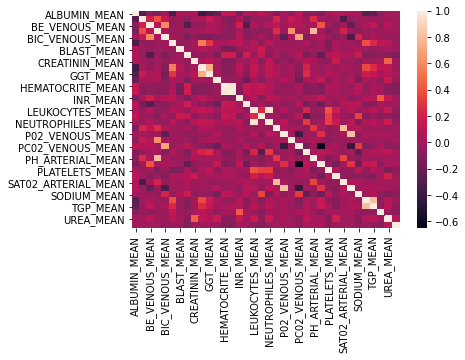

In [27]:
sns.heatmap(medical_test.corr(), annot=False);

Now, it looks better!

### Creating Final Dataset

Let's first remove the **DIFF** columns from the clean_data dataset.

In [28]:
mean_columns = [i for i in range(13, 192, 5)]
removing_columns = list(set(range(12, 192)) - set(mean_columns))
clean_data.drop(columns=clean_data.columns[removing_columns], inplace=True)

In [29]:
clean_data.head()

,AGE_ABOVE65,AGE_PERCENTIL,GENDER,HTN,IMMUNOCOMPROMISED,OTHER,Motor Neurone Disease,Smoker,Lung cancer,asthma,Kidney disease,heart disease,ALBUMIN_MEAN,BE_ARTERIAL_MEAN,BE_VENOUS_MEAN,BIC_ARTERIAL_MEAN,BIC_VENOUS_MEAN,BILLIRUBIN_MEAN,BLAST_MEAN,CALCIUM_MEAN,CREATININ_MEAN,FFA_MEAN,GGT_MEAN,GLUCOSE_MEAN,HEMATOCRITE_MEAN,HEMOGLOBIN_MEAN,INR_MEAN,LACTATE_MEAN,LEUKOCYTES_MEAN,LINFOCITOS_MEAN,NEUTROPHILES_MEAN,P02_ARTERIAL_MEAN,P02_VENOUS_MEAN,PC02_ARTERIAL_MEAN,PC02_VENOUS_MEAN,PCR_MEAN,PH_ARTERIAL_MEAN,PH_VENOUS_MEAN,PLATELETS_MEAN,POTASSIUM_MEAN,...,TTPA_MEAN,UREA_MEAN,DIMER_MEAN,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,ICU
0,1,60th,0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.605263,-1.0,-1.0,-0.317073,-0.317073,-0.938950,-1.0,0.183673,-0.868365,-0.742004,-0.945093,-0.891993,0.090147,0.109756,-0.932246,1.000000,-0.835844,-0.914938,-0.868747,-0.170732,-0.704142,-0.77931,-0.754601,-0.875236,0.234043,0.363636,-0.540721,-0.518519,...,-0.825613,-0.836145,-0.994912,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1
1,0,10th,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.605263,-1.0,-1.0,-0.317073,-0.317073,-0.938950,-1.0,0.357143,-0.912243,-0.742004,-0.958528,-0.780261,0.144654,0.158537,-0.959849,1.000000,-0.382773,-0.908714,-0.412965,-0.170732,-0.704142,-0.77931,-0.754601,-0.939887,0.234043,0.363636,-0.399199,-0.703704,...,-0.846633,-0.836145,-0.978029,-0.489712,-0.685470,-0.048218,-0.645951,0.357143,0.935673,-0.506173,-0.815385,-0.056604,-0.517241,0.357143,0.947368,-0.525773,-0.5125,-0.111111,-0.714286,0.604396,0.959596,-0.435897,-0.491892,0.000000,-0.575758,0.101449,1.000000,-0.547826,-0.533742,-0.603053,-0.764706,-1.000000,-0.959596,-0.515528,-0.351328,-0.747001,-0.756272,-1.000000,-0.961262,1
2,0,40th,1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.263158,-1.0,-1.0,-0.317073,-0.317073,-0.972789,-1.0,0.326531,-0.968861,-0.194030,-0.316589,-0.891993,-0.203354,-0.219512,-0.959849,-0.828421,-0.729239,-0.836100,-0.784714,-0.170732,-0.633136,-0.77931,-0.779141,-0.503592,0.234043,0.363636,-0.564753,-0.777778,...,-0.846633,-0.937349,-0.978029,0.012346,-0.369231,-0.528302,-0.457627,-0.285714,0.684211,0.012346,-0.369231,-0.528302,-0.448276,-0.285714,0.684211,0.175258,-0.1125,-0.384615,-0.357143,0.208791,0.878788,-0.299145,-0.556757,-0.626866,-0.515152,-0.420290,0.684211,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0
3,0,10th,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.605263,-1.0,-1.0,-0.317073,-0.317073,-0.935113,-1.0,0.357143,-0.913659,-0.829424,-0.938084,-0.851024,0.358491,0.304878,-0.959849,1.000000,-0.702202,-0.641079,-0.812725,-0.170732,-0.704142,-0.77931,-0.754601,-0.990926,0.234043,0.363636,-0.457944,-0.592593,...,-0.846633,-0.903614,-1.000000,0.333333,-0.153846,0.160377,-0.593220,0.285714,0.868421,0.333333,-0.153846,0.160377,-0.586207,0.285714,0.868421,0.443299,0.0000,0.196581,-0.571429,0.538462,0.939394,-0

You can see from the above table that the only Categorical feature remaining in the data is **AGE_PERCENTIL**. Therefore we need to convert it to a one-hot encoding.

In [30]:
one_hot_age = pd.get_dummies(clean_data[['AGE_PERCENTIL']])
final_data = pd.concat([one_hot_age, clean_data], axis =1)
final_data.drop(['AGE_PERCENTIL'], axis=1, inplace=True)
print(final_data.shape)
final_data.head()

(353, 94)


,AGE_PERCENTIL_10th,AGE_PERCENTIL_20th,AGE_PERCENTIL_30th,AGE_PERCENTIL_40th,AGE_PERCENTIL_50th,AGE_PERCENTIL_60th,AGE_PERCENTIL_70th,AGE_PERCENTIL_80th,AGE_PERCENTIL_90th,AGE_PERCENTIL_Above 90th,AGE_ABOVE65,GENDER,HTN,IMMUNOCOMPROMISED,OTHER,Motor Neurone Disease,Smoker,Lung cancer,asthma,Kidney disease,heart disease,ALBUMIN_MEAN,BE_ARTERIAL_MEAN,BE_VENOUS_MEAN,BIC_ARTERIAL_MEAN,BIC_VENOUS_MEAN,BILLIRUBIN_MEAN,BLAST_MEAN,CALCIUM_MEAN,CREATININ_MEAN,FFA_MEAN,GGT_MEAN,GLUCOSE_MEAN,HEMATOCRITE_MEAN,HEMOGLOBIN_MEAN,INR_MEAN,LACTATE_MEAN,LEUKOCYTES_MEAN,LINFOCITOS_MEAN,NEUTROPHILES_MEAN,...,TTPA_MEAN,UREA_MEAN,DIMER_MEAN,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,ICU
0,0,0,0,0,0,1,0,0,0,0,1,0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.605263,-1.0,-1.0,-0.317073,-0.317073,-0.938950,-1.0,0.183673,-0.868365,-0.742004,-0.945093,-0.891993,0.090147,0.109756,-0.932246,1.000000,-0.835844,-0.914938,-0.868747,...,-0.825613,-0.836145,-0.994912,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1
1,1,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.605263,-1.0,-1.0,-0.317073,-0.317073,-0.938950,-1.0,0.357143,-0.912243,-0.742004,-0.958528,-0.780261,0.144654,0.158537,-0.959849,1.000000,-0.382773,-0.908714,-0.412965,...,-0.846633,-0.836145,-0.978029,-0.489712,-0.685470,-0.048218,-0.645951,0.357143,0.935673,-0.506173,-0.815385,-0.056604,-0.517241,0.357143,0.947368,-0.525773,-0.5125,-0.111111,-0.714286,0.604396,0.959596,-0.435897,-0.491892,0.000000,-0.575758,0.101449,1.000000,-0.547826,-0.533742,-0.603053,-0.764706,-1.000000,-0.959596,-0.515528,-0.351328,-0.747001,-0.756272,-1.000000,-0.961262,1
2,0,0,0,1,0,0,0,0,0,0,0,1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.263158,-1.0,-1.0,-0.317073,-0.317073,-0.972789,-1.0,0.326531,-0.968861,-0.194030,-0.316589,-0.891993,-0.203354,-0.219512,-0.959849,-0.828421,-0.729239,-0.836100,-0.784714,...,-0.846633,-0.937349,-0.978029,0.012346,-0.369231,-0.528302,-0.457627,-0.285714,0.684211,0.012346,-0.369231,-0.528302,-0.448276,-0.285714,0.684211,0.175258,-0.1125,-0.384615,-0.357143,0.208791,0.878788,-0.299145,-0.556757,-0.626866,-0.515152,-0.420290,0.684211,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.605263,-1.0,-1.0,-0.317073,-0.317073,-0.935113,-1.0,0.357143,-0.913659,-0.829424,-0.938084,-0.851024,0.358491,0.304878,-0.959849,1.000000,-0.702202,-0.641079,-0.812725,...,-0.846633,-0.903614,-1.000000,0.333333,-0.153846,0.160377,-0.593220,0.285714,0.868421,0.333333,-0.153846,0.160377,-0.586207,0.285714,0.868421,0.443299,0.0000,0.196581,-0.571429,0.538462,0.939394,-0.076923,-0.351351,-0.044776,-0.575758,0.072464,0.894737,-1.000000,-0.877301,-0.923664,-0.882353,-0.952381,-0.979798,-1.000000,-0.883669,-0.956805,-0.870968,-0.953536,-0.980333,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.60526

**Now everything is ready to start MODELLING**

# Try Different Machine Learning Models

## Train/Test Split

In [31]:
np.random.seed(0)
icu = final_data.copy()
columns = final_data.columns
X = icu[columns].drop(['ICU'], axis=1)
y = icu['ICU']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, stratify=y, random_state= 0)
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (282, 93)
X_test shape: (71, 93)
y_train shape: (71,)
y_test shape: (71,)


In [32]:
models_results= {}

## 1. Logistic Regression

Here we train our data with Logistic Regression model with the help of K-fold Cross Validation technique.

In [33]:
np.random.seed(0)
cross_validation = KFold(n_splits=10, random_state=1, shuffle=True)
logistic_model = LogisticRegression()
scores_logistic = cross_validate(logistic_model, X, y, scoring= ['accuracy', 'roc_auc', 'f1'], cv=cross_validation, n_jobs=-1, return_estimator =True)
# report performance
logistic_accuracy = np.mean(scores_logistic['test_accuracy']).round(2)
logistic_AUC = np.mean(scores_logistic['test_roc_auc']).round(2)
logistic_f1 =  np.mean(scores_logistic['test_f1']).round(2)
models_results['Logistic Regression'] = (logistic_accuracy, logistic_AUC, logistic_f1)
print('Accuracy: ', logistic_accuracy)
print('AUC: ', logistic_AUC)
print('f1-score:', logistic_f1)

Accuracy:  0.74
AUC:  0.78
f1-score: 0.71


## 2. Random Forrest Classifier

Here we want to try the random forrest classifier. In order to find the best parameters for this classifier, we use the **Grid Search Cross Validation**.

**Hyperparameter Tunning**

In [34]:
parameters = {'n_estimators':[10,20,25], 'criterion':['entropy', 'gini'], 'max_depth':range(5, 20), 'max_features':['sqrt','log2', 'auto'], 'bootstrap': ['True', 'False']}

grid_search_cv = GridSearchCV(RandomForestClassifier(), parameters, scoring = 'f1')
grid_search_cv.fit(X_train, y_train)
print(grid_search_cv.best_score_)
grid_search_cv.best_estimator_

0.7297797133619649


RandomForestClassifier(bootstrap='False', ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=12, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=20,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Now, based on what we learned above, we will creat the best model and train it.

In [35]:
best = grid_search_cv.best_estimator_
random_forrest_model = RandomForestClassifier(bootstrap=best.bootstrap, max_depth=best.max_depth, max_features=best.max_features, n_estimators=best.n_estimators, criterion=best.criterion, random_state= 0)
random_forrest_model.fit(X_train,y_train)
pred = random_forrest_model.predict(X_test)
random_forrest_accuracy = accuracy_score(y_test, pred).round(2)
random_forrest_AUC = roc_auc_score(y_test, pred).round(2)
random_forrest_f1 =  f1_score(y_test, pred).round(2)
models_results['Random Forrest'] = (random_forrest_accuracy, random_forrest_AUC, random_forrest_f1)
print('Accuracy: ', random_forrest_accuracy)
print('AUC: ', random_forrest_AUC)
print('f1-score:', random_forrest_f1)

Accuracy:  0.73
AUC:  0.73
f1-score: 0.71


## 3. Extra Tree Classifier

Here we want to try the Extra Tree classifier. In order to find the best parameters for this classifier, we again use the **Grid Search Cross Validation**.

**Difference Between Random Forrest and Decision Tree**: Random Forest chooses the optimum split while Extra Trees chooses it randomly. However, once the split points are selected, the two algorithms choose the best one between all the subset of features. Therefore, Extra Trees adds randomization but still has optimization

**Hyperparameter Tunning**

In [36]:
parameters = {'n_estimators':[10,20,25], 'criterion':['entropy', 'gini'], 'max_depth':range(5, 20), 'max_features':['sqrt','log2', 'auto'], 'bootstrap': ['True', 'False']}

grid_search_cv = GridSearchCV(ExtraTreesClassifier(), parameters, scoring = 'f1')
grid_search_cv.fit(X_train, y_train)
print(grid_search_cv.best_score_)
grid_search_cv.best_estimator_

0.716702662416948


ExtraTreesClassifier(bootstrap='False', ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=19, max_features='sqrt',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
                     oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

Now, based on what we learned above, we will creat the best model and train it.

In [37]:
best = grid_search_cv.best_estimator_
extra_tree_model = ExtraTreesClassifier(bootstrap=best.bootstrap, max_depth=best.max_depth, max_features=best.max_features, n_estimators=best.n_estimators, criterion=best.criterion, random_state= 0)
extra_tree_model.fit(X_train,y_train)
pred = extra_tree_model.predict(X_test)
extra_tree_accuracy = accuracy_score(y_test, pred).round(2)
extra_tree_AUC = roc_auc_score(y_test, pred).round(2)
extra_tree_f1 =  f1_score(y_test, pred).round(2)
models_results['Extra Tree'] = (extra_tree_accuracy, extra_tree_AUC, extra_tree_f1)
print('Accuracy: ', extra_tree_accuracy)
print('AUC: ', extra_tree_AUC)
print('f1-score:', extra_tree_f1)

Accuracy:  0.7
AUC:  0.7
f1-score: 0.69


## 4. Naive Bayes

Here we train our data with Gaussian Naive Bayes model with the help of K-fold Cross Validation technique.

In [38]:
np.random.seed(0)
cross_validation = KFold(n_splits=10, random_state=1, shuffle=True)
bayes_model = GaussianNB()
scores_bayes = cross_validate(bayes_model, X, y, scoring= ['accuracy', 'roc_auc', 'f1'], cv=cross_validation, n_jobs=-1)
# report performance
bayes_accuracy = np.mean(scores_bayes['test_accuracy']).round(2)
bayes_AUC = np.mean(scores_bayes['test_roc_auc']).round(2)
bayes_f1 =  np.mean(scores_bayes['test_f1']).round(2)
models_results['Naive Bayes'] = (bayes_accuracy, bayes_AUC, bayes_f1)
print('Accuracy: ', bayes_accuracy)
print('AUC: ', bayes_AUC)
print('f1-score:', bayes_f1)

Accuracy:  0.59
AUC:  0.74
f1-score: 0.26


## 5. Support Vector Machine (SVM)

Here we want to try the SVM classifier. In order to find the best parameters for this classifier, we again use the **Grid Search Cross Validation**.

**Hyperparameter Tunning**

In [39]:
parameters = {'C': [0.01, 1, 5], 'coef0': [1.0, 5.0, 10.0], 'degree': [1,2,3,4,5], 'gamma': ['scale', 'auto', 0.1, 1], 'probability': [True, False]}
grid_search_cv = GridSearchCV(SVC(),parameters, scoring = 'f1', cv=10)
grid_search_cv.fit(X_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.01, 1, 5], 'coef0': [1.0, 5.0, 10.0],
                         'degree': [1, 2, 3, 4, 5],
                         'gamma': ['scale', 'auto', 0.1, 1],
                         'probability': [True, False]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1', verbose=0)

Now, based on what we learned above, we will creat the best model and train it.

In [40]:
best = grid_search_cv.best_estimator_
svm_model = SVC(C=best.C, coef0=best.coef0, degree=best.degree, gamma=best.gamma, kernel='linear', random_state= 0)
svm_model.fit(X_train,y_train)
pred = svm_model.predict(X_test)
svm_accuracy = accuracy_score(y_test, pred).round(2)
svm_AUC = roc_auc_score(y_test, pred).round(2)
svm_f1 =  f1_score(y_test, pred).round(2)
models_results['SVM'] = (svm_accuracy, svm_AUC, svm_f1)
print('Accuracy: ', svm_accuracy)
print('AUC: ', svm_AUC)
print('f1-score:', svm_f1)

Accuracy:  0.75
AUC:  0.75
f1-score: 0.73


#Final Model

## Finding the Final Model

Let us compare the models with three metrics : 1. Accuracy, 2. F1-score and 3. AUC.

Text(0.5, 0.98, 'Model Comparison')

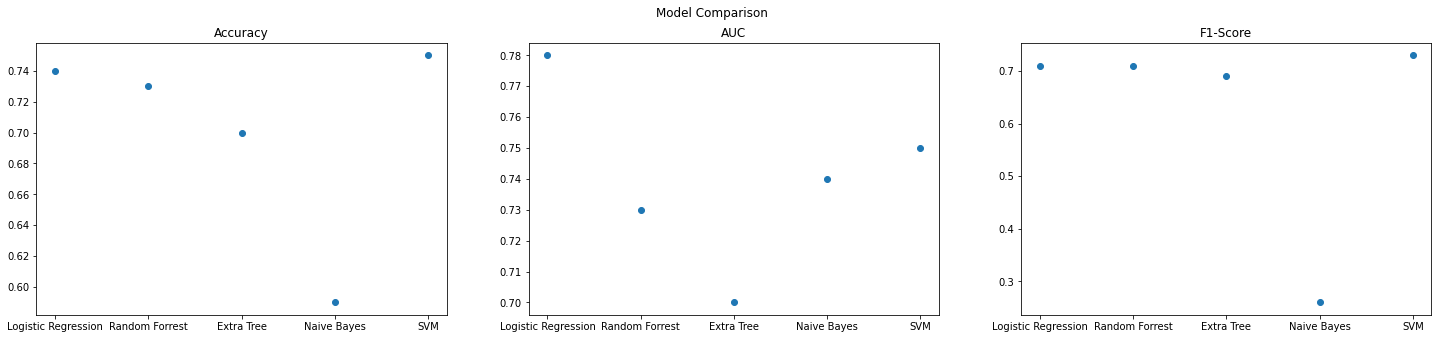

In [46]:
names = list(models_results.keys())
values1 = []
values2 = []
values3 = []
for value in models_results.values():
  values1.append(value[0])
  values2.append(value[1])
  values3.append(value[2])

fig, axs = plt.subplots(1, 3, figsize=(25, 5))
axs[0].scatter(names, values1)
axs[0].title.set_text('Accuracy')
axs[1].scatter(names, values2)
axs[1].title.set_text('AUC')
axs[2].scatter(names, values3)
axs[2].title.set_text('F1-Score')
fig.suptitle('Model Comparison')

We can see from the above chart, the **SVM Classifier** is performing better (overall) in comparison to the other models. 

## Feature Importance

Here we want to see which features where most important for the SVM Classifier model to make the decision.

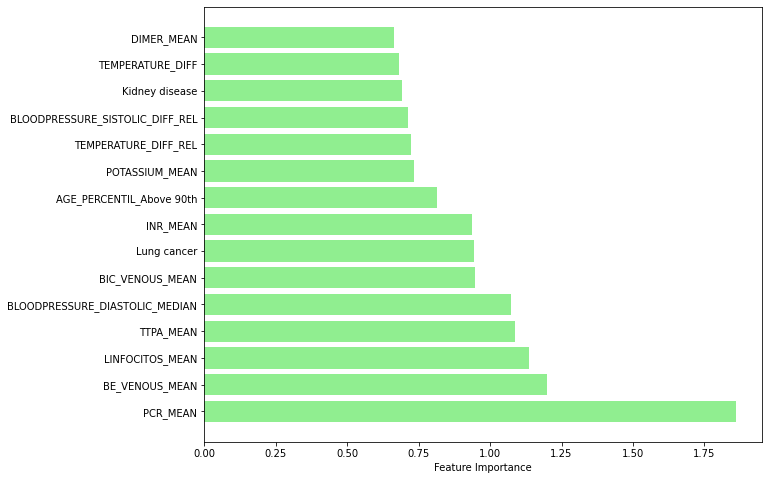

In [42]:
def f_importances(coef, names, top=-1):
    imp = coef
    imp, names = zip(*sorted(list(zip(imp, names))))

    if top == -1:
        top = len(names)
    plt.figure(figsize=(10,8))
    plt.xlabel('Feature Importance')
    plt.barh(range(top), imp[::-1][0:top], align='center', color = 'lightgreen')
    plt.yticks(range(top), names[::-1][0:top])
    plt.show()

f_importances(abs(svm_model.coef_[0]), list(final_data.columns), top=15)